<a href="https://colab.research.google.com/github/HuiDiHu/Malaria-Diagnosis-using-Streamlit-2022/blob/main/Malaria_Diagnosis_using_Streamlit_%7C_Huidi_Hu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Convolution Method**: Modified U-net


---



In [ ]:
#1/18: Fixing overfitting bug
#Credits to Inspirit AI for imports template/data
#networking protocal
#generate circle aroud weakpoint 3/15
#completed weakpoints 3/22
!pip -q install pyngrok
!pip -q install streamlit
!pip -q install patool
####
import cv2
import gdown
import glob
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import patoolib

from joblib import dump
from pyngrok import ngrok
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

DATA_ROOT = '/content'
os.makedirs(DATA_ROOT, exist_ok=True)
max_samples = 3000

blood_slide_url = 'https://drive.google.com/uc?id=1lffxAG8gykh1dh1pCP34uRkH3XMwuNt-'
blood_slide_path = os.path.join(DATA_ROOT, 'blood_slide.jpg')
gdown.download(blood_slide_url, blood_slide_path, True)

!wget "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/malaria_images.zip"
!unzip "malaria_images.zip"
malaria_imgs_path = os.path.join(DATA_ROOT, 'malaria_images.zip')

print("Downloaded Data")

u_malaria_img_paths = glob.glob('/content/malaria_images/Uninfected/*png')
p_malaria_img_paths = glob.glob('/content/malaria_images/Parasitized/*png')

NUM_SAMPLES = len(u_malaria_img_paths) + len(p_malaria_img_paths)

X = []
y = []

X_g = []

def categorical_to_numpy(labels_in):
  labels = []
  for label in labels_in:
    if label == 'dog':
      labels.append(np.array([1, 0]))
    else:
      labels.append(np.array([0, 1]))
  return np.array(labels)

def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')
    ax.legend(loc = 1)
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')

    plt.show()

for i in tqdm(range(max_samples)):
  img = cv2.imread(u_malaria_img_paths[i])
  X.append(cv2.resize(img,(50,50)))

  gray_img = cv2.imread(u_malaria_img_paths[i],0)
  X_g.append(cv2.resize(gray_img,(50,50)))

  y.append(0)

for i in tqdm(range(max_samples)):
  img = cv2.imread(p_malaria_img_paths[i])
  X.append(cv2.resize(img,(50,50)))

  gray_img = cv2.imread(p_malaria_img_paths[i],0)
  X_g.append(cv2.resize(gray_img,(50,50)))

  y.append(1)

X = np.stack(X)
X_g = np.stack(X_g)
X_reshaped = np.reshape(X_g,(X_g.shape[0],2500))

y = np.array(y)

blood_samples_dir = 'blood_samples'
if (os.path.exists(blood_samples_dir) == False):
  os.mkdir(blood_samples_dir)

for i, img in enumerate(X[2995:3005]):
  plt.imsave('test_img_{}.jpg'.format(i), img)

print("Created our X and y variables")


Streaming output truncated to the last 5000 lines.
  inflating: malaria_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: malaria_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: malaria_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: malaria_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: malaria_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: malaria_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: malaria_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: malaria_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: malaria_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: malaria_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_87.png  
  inflating: malaria_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_91.png  
  inflating: malaria_images

100%|██████████| 3000/3000 [00:03<00:00, 801.10it/s]

Created our X and y variables


# Malaria Diagnosis

(6000, 50, 50, 3)
(6000,)
1


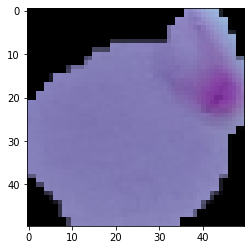

In [ ]:
print(X.shape)
print(y.shape)
index=0
cState=1
for i in range (6000):
  if y[i] == cState:
    index=i
    break
plt.imshow(X[index])
print(y[index])

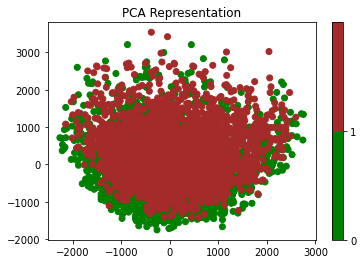

In [ ]:
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_reshaped)

colors = ["green","brown"]
classes = [0,1]

plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap=matplotlib.colors.ListedColormap(colors))
cb = plt.colorbar()
loc = np.arange(0,max(y),max(y)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(classes)
plt.title("PCA Representation")
#cb.set_tickets(loc, classes)
####
plt.show()

#Training

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X.astype(float), categorical_to_numpy(y), random_state=101, test_size=0.2)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(4800, 50, 50, 3)
(4800, 2)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, InputLayer
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape
from keras.utils.np_utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
#Overfitting bug
def CNNClassifier(epochs=15, layers=5, dropout=0.25):
  model = Sequential()
  #model.add(Reshape((50, 50, 3)))

  for i in range(layers):
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))

  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(dropout))

  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(dropout))

  model.add(Flatten())
  model.add(Dense(7500))
  model.add(Activation('relu'))
  model.add(Dropout(dropout))
  model.add(Dense(2))
  model.add(Activation('softmax'))

  opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

  model.compile(loss='categorical_crossentropy', optimizer=opt,
            metrics=['accuracy'])
  return model


In [ ]:
cnn = CNNClassifier()

In [ ]:
history = cnn.fit(X_train, y_train, validation_data=(X_test, y_test))
#plot_acc(history)

In [ ]:
model = CNNClassifier()
model.fit(X_train, y_train)

In [ ]:
# Your Code Here
print(cnn.evaluate(X_test, y_test))

In [ ]:
dump(cnn, "cnn.joblib")

['cnn.joblib']

In [ ]:
%%writefile website.py
import streamlit as st
from joblib import load
import numpy as np
import cv2

model = load("cnn.joblib")

st.title('Malaria Diagnosis') #Change the title here!
st.subheader("Diagnose Blood Slide Images")

#Later: add more Streamlit code here
uploaded_file = st.file_uploader("Upload File")
if uploaded_file is not None:
  file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
  image = cv2.imdecode(file_bytes, 1)
  st.image(image, caption="Input Image", channels="BGR")
  small = cv2.resize(image, (50,50))
  #small_flat = np.reshape(small, (1, 7500))
  small = np.reshape(small, (1,50,50,3))
  #st.write(small.shape)
  #gray_flat = np.reshape(gray,(1,2500))
  prediction = model.predict(small)
  if np.argmax(prediction) == 0:
    st.write('Malaria Detected')
  else:
    st.write('No Malaria Detected')





Writing website.py


In [ ]:
public_url = ngrok.connect(port='80')
print (public_url)
!streamlit run --server.port 80 website.py >/dev/null

NgrokTunnel: "http://8372-34-171-30-123.ngrok.io" -> "http://localhost:80"


In [ ]:
# auth token | DO THIS BEFORE ABOVE
!ngrok authtoken 29TzLt2bef6PoWTNpYjRaWv7AKB_59u1NdHXojcDih9MYnQyc

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
import streamlit as st
uploaded_file = st.file_uploader("Upload File")
if uploaded_file is not None:
    pass

  command:

    streamlit run /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py [ARGUMENTS]
2022-10-30 07:07:13.178 
  command:

    streamlit run /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py [ARGUMENTS]


In [ ]:
#No longer needed
file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
image = cv2.imdecode(file_bytes, 1)

In [ ]:
small = cv2.resize(image, (50,50))
gray = cv2.cvtColor(small, cv2.COLOR_BGR2GRAY)

TBD